In [1]:
%%capture
!pip install albumentations==1.4.24 deepforest

In [2]:
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd
import deepforest
from deepforest import main
from deepforest import get_data
import matplotlib
from matplotlib import pyplot as plt
import torch

/srv/conda/envs/notebook/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
model = main.deepforest()
model.load_model(model_name="weecology/deepforest-tree", revision="main")
model

Reading config file: /srv/conda/envs/notebook/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /srv/conda/envs/notebook/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


deepforest(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias

In [4]:
# This could just as easily be a COG from planetary computer or otherwise
img = rioxarray.open_rasterio("../data_in/teak_mortality/2019_TEAK_4_320000_4097000_image.tif").transpose("y", "x", "band")
img

<xarray.DataArray (y: 10000, x: 10000, band: 3)> Size: 300MB
[300000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 80kB 3.2e+05 3.2e+05 3.2e+05 ... 3.21e+05 3.21e+05
  * y            (y) float64 80kB 4.098e+06 4.098e+06 ... 4.097e+06 4.097e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      .\L3\Camera\Mosaic\\2019_TEAK_4_320000_4097000...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.5.2, Exelis Visual Information Solutions...
    TIFFTAG_DATETIME:          2019:08:25 17:52:45
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

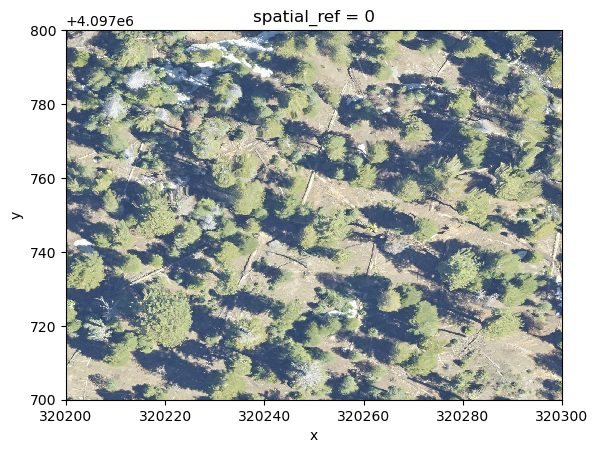

In [5]:
img_slice = img.isel(x=slice(2000, 3000), y=slice(2000, 3000))
img_slice.plot.imshow()

In [6]:
# channels need to be last
predict_result = model.predict_image(image=img_slice.values)

In [7]:
predict_result.head()

,xmin,ymin,xmax,ymax,label,score,geometry
0,749.0,601.0,838.0,700.0,Tree,0.765864,"POLYGON ((838 601, 838 700, 749 700, 749 601, ..."
1,0.0,603.0,83.0,703.0,Tree,0.746258,"POLYGON ((83 603, 83 703, 0 703, 0 603, 83 603))"
2,129.0,704.0,257.0,840.0,Tree,0.733355,"POLYGON ((257 704, 257 840, 129 840, 129 704, ..."
3,628.0,697.0,691.0,764.0,Tree,0.698359,"POLYGON ((691 697, 691 764, 628 764, 628 697, ..."
4,285.0,911.0,366.0,995.0,Tree,0.680576,"POLYGON ((366 911, 366 995, 285 995, 285 911, ..."


In [8]:
predict_result["width"] = predict_result["xmax"] - predict_result["xmin"]
predict_result["height"] = predict_result["ymax"] - predict_result["ymin"]

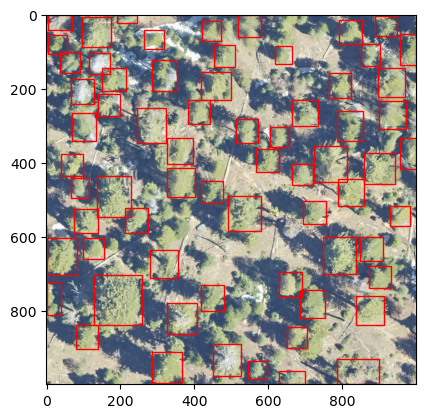

In [9]:
fig, ax = plt.subplots()
ax.imshow(img_slice.values)
for idx, row in predict_result.iterrows():
    rect = matplotlib.patches.Rectangle((row["xmin"], row["ymin"]), width=row["width"], height=row["height"], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [10]:
cropmodel = deepforest.model.CropModel.load_from_checkpoint("../data_in/weecology/cropmodel-deadtrees.pl", num_classes=2)

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../data_in/weecology/cropmodel-deadtrees.pl`


In [11]:
def make_crop(img, bounds):
    xmin, ymin, xmax, ymax = bounds
    crop = img.isel(x=slice(xmin, xmax), y=slice(ymin, ymax)).values
    # Scale from 0-1
    crop = crop / 255
    # Convert to tensor
    crop = torch.tensor(crop)
    # Channel axis first
    crop = crop.permute(-1, 0, 1)
    # Flip channel order
    crop = torch.flip(crop, [0])
    # add batch dim
    crop = crop.unsqueeze(0)
    # convert to float32
    crop = crop.to(torch.float32)
    return crop

labels = np.zeros(predict_result.shape[0])

for idx, row in predict_result.iterrows():
    bounds = int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"])
    crop = make_crop(img_slice, bounds)
    likelihood = cropmodel(crop)
    labels[idx] = likelihood.argmax()

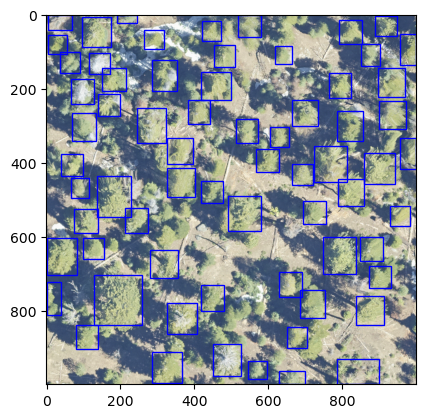

In [12]:
fig, ax = plt.subplots()
ax.imshow(img_slice.values)
for idx, row in predict_result.iterrows():
    edge = 'r' if labels[idx] > 0 else 'b'
    rect = matplotlib.patches.Rectangle((row["xmin"], row["ymin"]), width=row["width"], height=row["height"], 
                                        linewidth=1, edgecolor=edge, facecolor='none')
    ax.add_patch(rect)
plt.show()